# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [47]:
# Question 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('./data/cars_hw.csv')
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [48]:
# Convert 'No_of_Owners' to integer by extracting the numeric part
df['No_of_Owners'] = df['No_of_Owners'].str.extract('(\d)').astype(int)

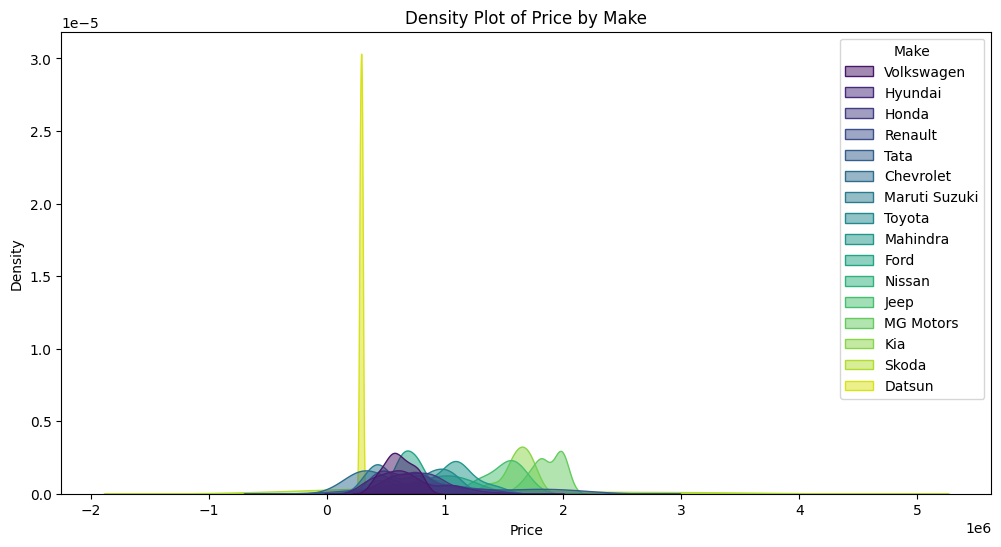

In [62]:
# Density plot of Price by Make
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Price', hue='Make', fill=True, common_norm=False, palette='viridis', alpha=0.5)
plt.title('Density Plot of Price by Make')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

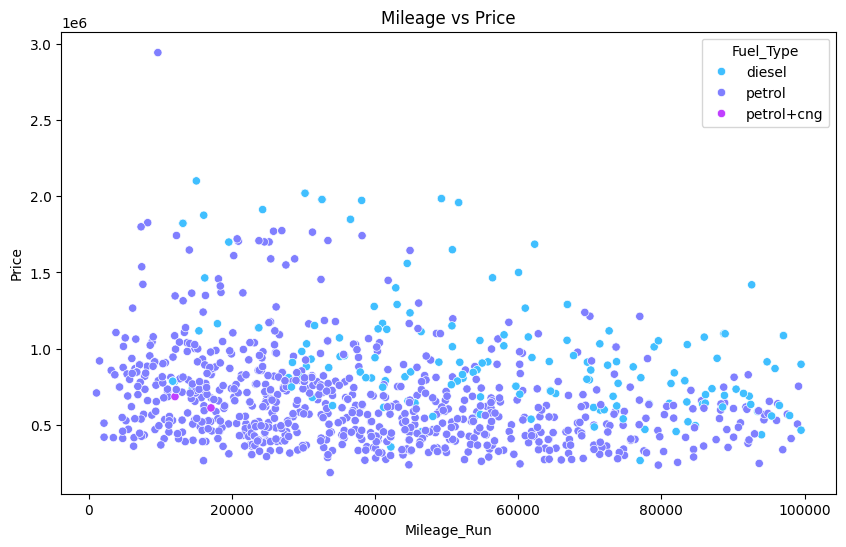

In [50]:
# Mileage vs. Price scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Mileage_Run', y='Price', hue='Fuel_Type', palette='cool')
plt.title('Mileage vs Price')
plt.show()

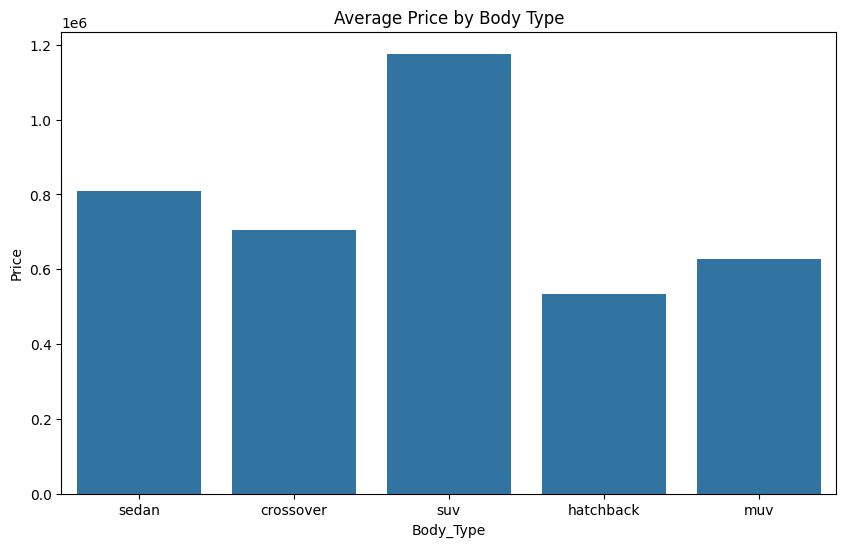

In [53]:
# Average price by Body_Type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Body_Type', y='Price', errorbar=None)  # Removed ci and palette
plt.title('Average Price by Body Type')
plt.show()

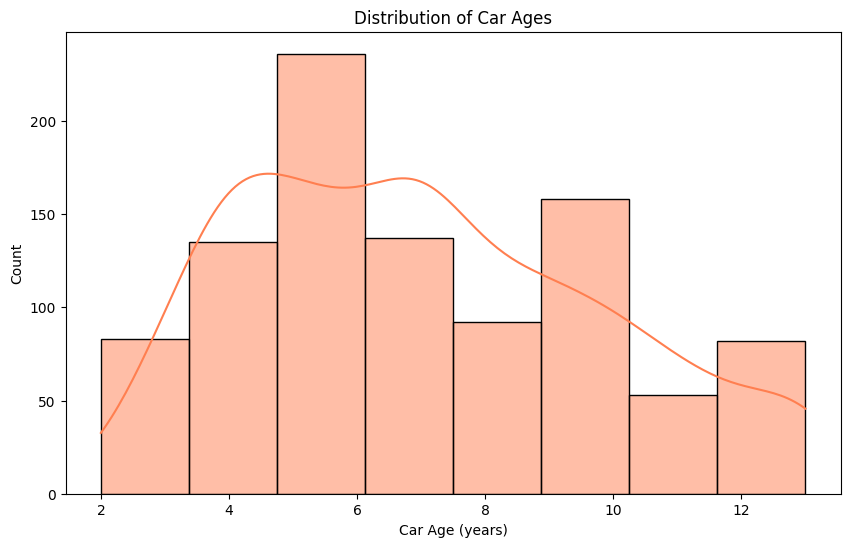

In [54]:
# Distribution of car ages
df['Car_Age'] = 2024 - df['Make_Year']
plt.figure(figsize=(10, 6))
sns.histplot(df['Car_Age'], kde=True, bins=8, color="coral")
plt.title('Distribution of Car Ages')
plt.xlabel('Car Age (years)')
plt.show()


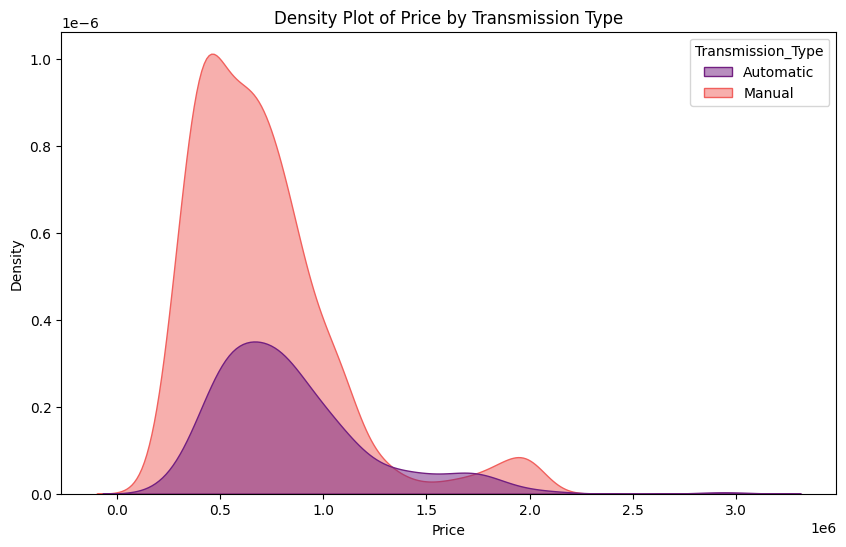

In [57]:
# Density plot of Price by Transmission_Type
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Price', hue='Transmission_Type', fill=True, palette='magma', alpha=0.5)  # Fill the density area
plt.title('Density Plot of Price by Transmission Type')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [69]:
# Question 2

# One-Hot Encoding for categorical columns (Make, Color, Body_Type, Fuel_Type, Transmission, Transmission_Type)
y = df['Price']
X = pd.get_dummies(df, columns=['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'], drop_first=True)


In [70]:
# Question 3

from sklearn.model_selection import train_test_split

y = df['Price']
X = df.loc[:, ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']]
# Perform 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [71]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align train and test sets to have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

model = LinearRegression()
model.fit(X_train_encoded, y_train)

y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Linear Regression'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
print(results)

               Model     Train RMSE      Test RMSE  Train R²   Test R²
0  Linear Regression  182905.971098  176006.321127  0.750588  0.774391


The Test set does the best, as it has the lowest RSME and the highest R^2 values.


In [73]:
# Question 5: Include transformations and interactions, and build a more complex model that reflects your ideas about
# how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How
# does the more complex model your build compare to the simpler ones?
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# One-hot encode categorical variables before applying polynomial features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align train and test sets to have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Create polynomial features
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_encoded)
X_test_poly = poly.transform(X_test_encoded)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

results_complex = pd.DataFrame({
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})

print(results_complex)

      Train RMSE     Test RMSE  Train R²       Test R²
0  122079.925059  1.281753e+17  0.888891 -1.196490e+23


In the more complex model, the Test set has the greater RSME value and smaller R^2 value than the Train set. In the simpler model, it was the opposite.

6. Looking at the RSME and R^2 results from the simpler and complex models, it is evident that the Test test for the simpler model is more advisable to choose. Since the test set has a lower RSME and greater R^2 value than the train set, it has better performance and reflects a better balance between bias and variance. As a result, this can lead to more robust predictions in real-world applications, as the simpler model is less likely to be misled by noise in the training dataset. On the other hand, the train set for the complex model has better performance, as the RSME is lower and the R^2 is greater than the test set.

In [67]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Create polynomial features
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the Lasso model
alpha = 0.1
lasso_model = Lasso(alpha=alpha, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)

y_train_pred = lasso_model.predict(X_train_poly)
y_test_pred = lasso_model.predict(X_test_poly)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

feature_names = poly.get_feature_names_out(input_features=X_train_encoded.columns)
selected_features = feature_names[lasso_model.coef_ != 0]

results_lasso = pd.DataFrame({
    'Model': ['Lasso Regression'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    'Selected Features': [selected_features]
})

print(results_lasso)

              Model     Train RMSE      Test RMSE  Train R²   Test R²  \
0  Lasso Regression  121902.657278  288343.455805  0.889213  0.394491   

                                   Selected Features  
0  [Make_Datsun, Make_Ford, Make_Honda, Make_Hyun...  


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.509e+12, tolerance: 1.046e+10
  model = cd_fast.enet_coordinate_descent(
